In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SEIR_stochastic, plot_samples, plot_forecast, plot_R0
import util


Bad key "nbagg.transparent" on line 426 in
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an update

# Run Inference

In [2]:
data = util.load_state_data("jhu")

#places = state_data.keys()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY', 'MA', 'WA', 'AK', 'WV']
#places = ['US']
#places = ['NY']
places = ['MI']#sorted(['NY', 'WA', 'MA', 'MI', 'AL', 'AR', 'KY'])

save = True
for place in places:
    util.run_place(data, place, save=save, start='2020-03-15', num_warmup=100, num_samples=100,
                  drift_scale=1e1)


******* MI *********
Running MCMC


sample: 100%|██████████| 200/200 [00:52<00:00,  3.81it/s, 255 steps of size 1.31e-02. acc. prob=0.89] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          D0      1.30      0.98      1.08      0.09      2.82    153.54      0.99
          E0    469.76    352.32    385.33     32.65    992.47     77.04      0.99
          H0      3.84      3.01      3.03      0.10      7.51     92.23      1.00
          I0     89.34     21.83     89.68     52.62    123.30    111.87      0.99
     beta[0]     14.41      4.29     13.54      8.78     21.59     90.89      1.00
     beta[1]     12.40      3.93     11.20      7.14     19.14     61.57      1.01
     beta[2]     11.05      3.53     10.12      6.60     16.96     62.28      1.03
     beta[3]      9.90      3.22      9.30      5.23     14.32     50.19      1.05
     beta[4]      8.48      2.76      7.79      5.01     12.04     60.47      1.04
     beta[5]      7.47      2.39      6.91      4.33     10.95     66.81      1.05
     beta[6]      6.34      2.18      5.69      3.29      9.47     48.18      1.01
   

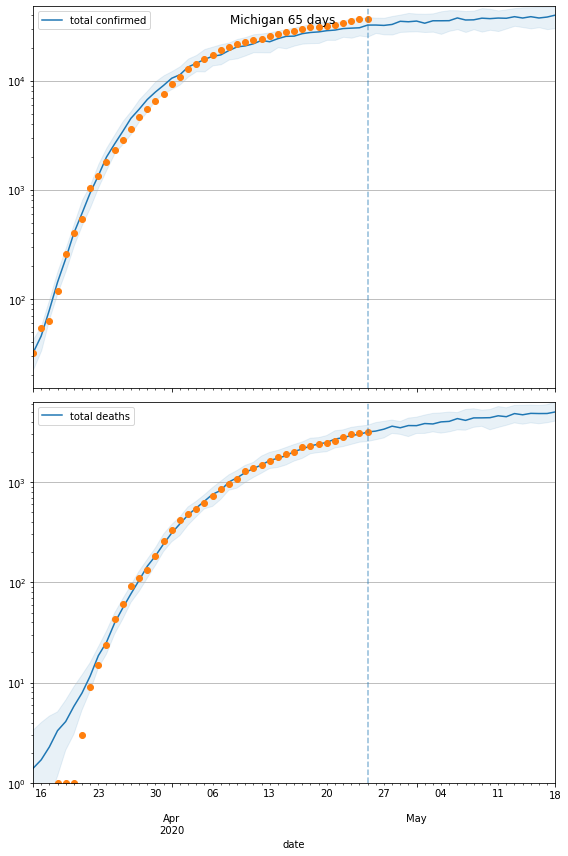

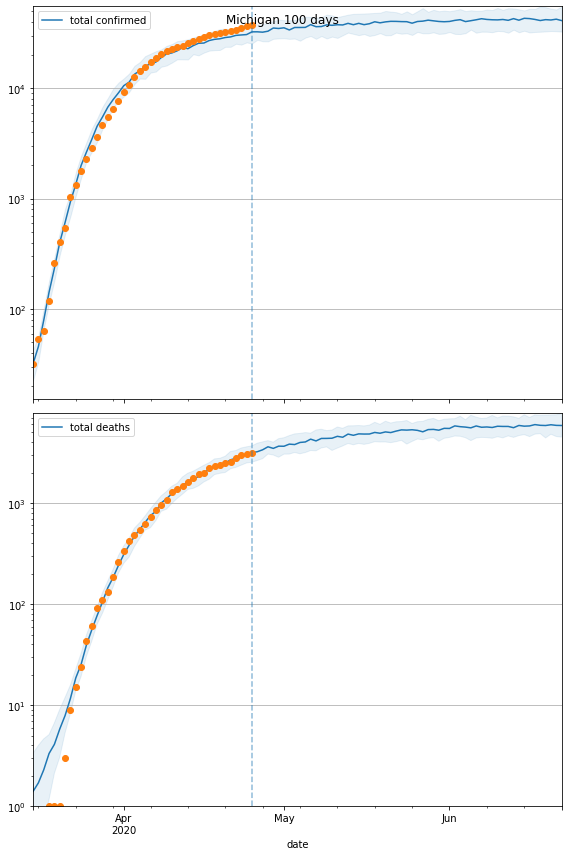

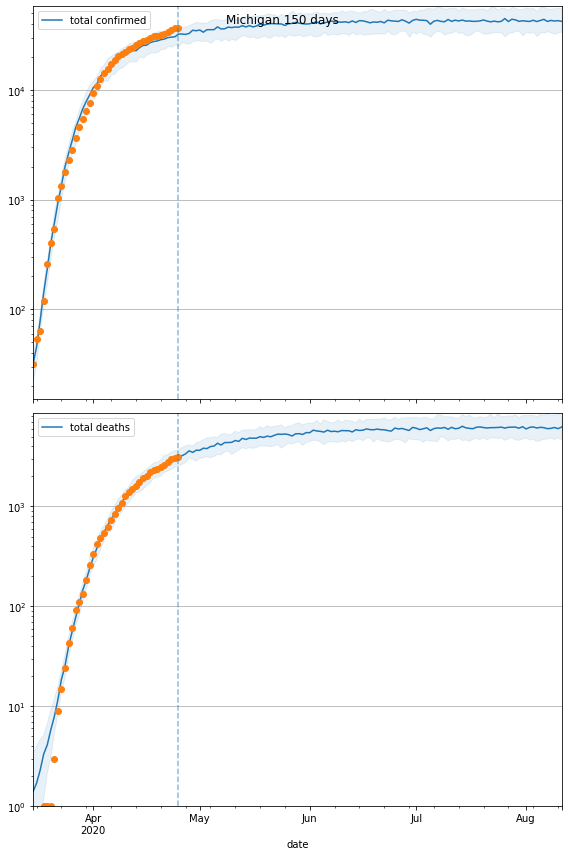

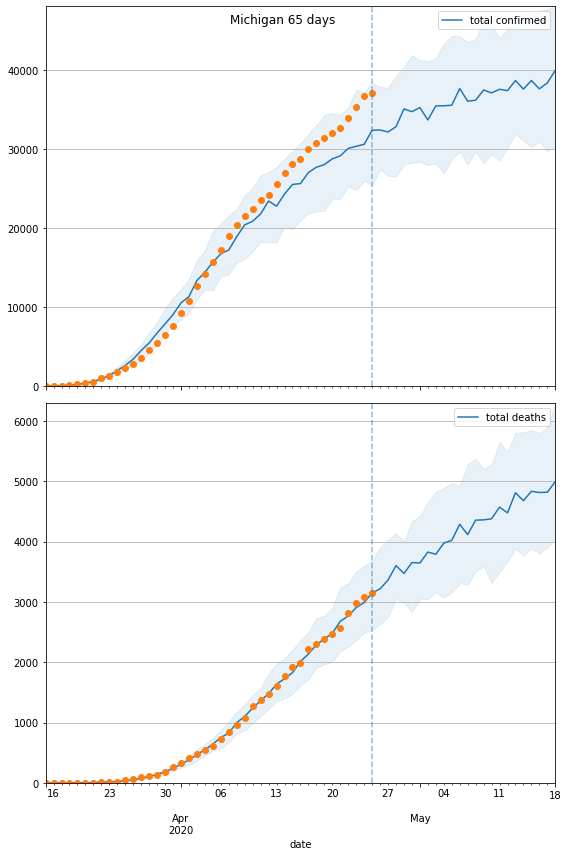

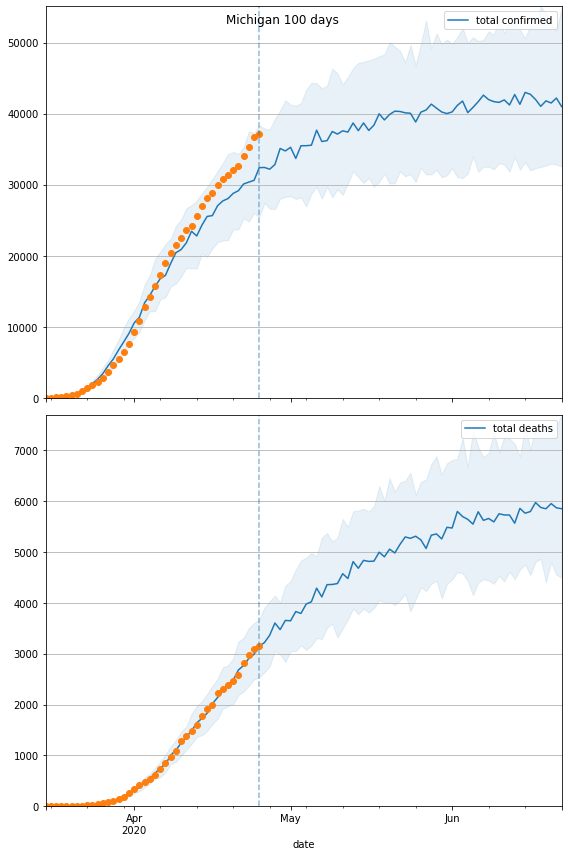

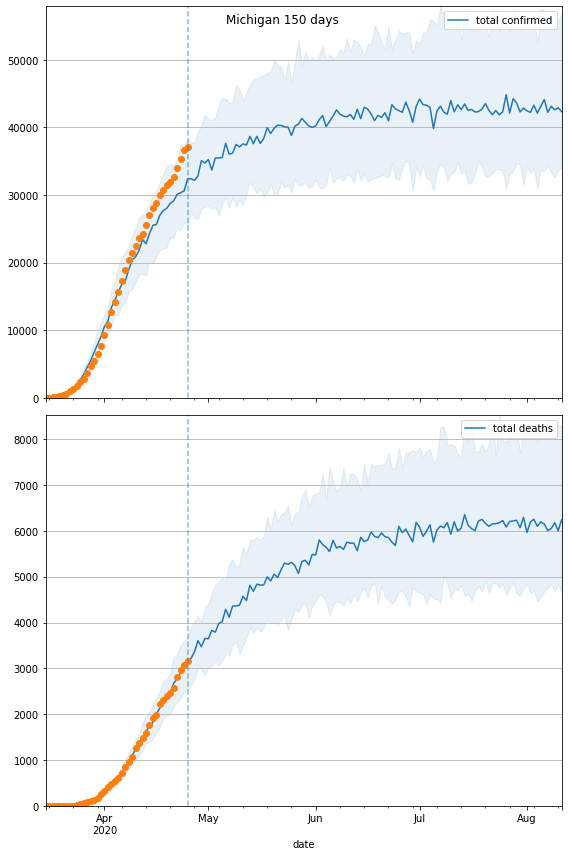

<Figure size 360x216 with 0 Axes>

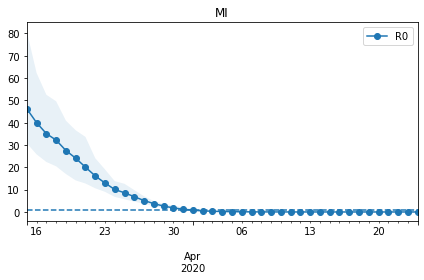

In [4]:

start = '2020-03-15'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['ID']
#places = ['NY']
#places = state_data.keys()
#places = ['AK']
#places = ['US']
#places = ['LA', 'NY']
#places = ['NY', 'MA', 'WA', 'AK', 'WV']
#places = ['CO']
#places = ['MI']
#places = ['NY', 'WA', 'MA']
places = ['MI']#sorted(['NY', 'WA', 'MA', 'MI', 'AL', 'AR', 'KY'])


save = False


# Inspect and Save Results 
for place in places:
    util.gen_forecasts(data, place, start=start, save=save, daily=False)

In [ ]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    

# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=0.1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

# Compare gamma and beta0 specifically
fig, ax = plt.subplots(figsize=(9,4), ncols=2)

xlim = [0, 6]
ylim = [0, 3]

for df, name, a in zip([prior_df, posterior_df], ['Prior', 'Posterior'], ax):
    sns.kdeplot(df['beta0'], 
                df['gamma'], 
                ax=a,
                shade=True, 
                shade_lowest=False)
    a.set_title(name)
    a.set_xlim(xlim)
    a.set_ylim(ylim)

plt.show()

In [ ]:
samples = post_pred_samples
X = np.concatenate((samples['x'], samples['x_future']), axis=1)

T = X.shape[1]
t = pd.date_range(start, freq='D', periods=T)
levels = 10

beta0 = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
inds = np.argsort(beta0)
level_inds = inds[np.linspace(0, len(I)-1, levels).astype('int32')]

fig, ax = plt.subplots(figsize=(12,14), nrows=5)


beta0_gamma = [f'({beta0[i]:.2f}, {gamma[i]:.2f})' for i in level_inds]

for col, name, a in zip([0, 1, 2, 3, 4], 
                       ['susceptible', 'exposed', 'infectious', 'removed', 'cum. infected'],
                       ax):

    X_levels = np.squeeze(X[level_inds,:,col].T)

    lines = []
    cmap = plt.cm.cool
    for i in range(levels):
        lines += a.plot(t, X_levels[:,i], color=cmap(i*30))

    a.set_title(name)
    
plt.legend(beta0_gamma)

plt.show()

In [ ]:
n = 50
for i in range(n):
    print(plt.cm.jet(i * n / 256))

In [ ]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, z, obs_rate, hosp_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x[:,1:])    
    l2 = ax2.plot(ts, y, 'x', color='r')
    l3 = ax2.plot(ts, z, 'x', color='k')
        
    plt.legend(l1 + l2 + l3, ['I', 'R', 'C', 'y', 'hosp'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N, det_conc=200)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
    return samples
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=100, T_future=100, N=1e8, use_hosp=True)
        
#    samples = test_prior_predictive()

In [ ]:
place = 'AZ'
prior_samples, mcmc_samples, post_pred_samples = util.load_samples(place)

plt.hist(prior_samples['hosp_rate'])
plt.show()

plt.hist(mcmc_samples['hosp_rate'])
plt.show()